<h1 align="center">Fusion d'images IRM et MALDI</h1>

## Contexte

**Objectif** : identifier de nouvelles molécules liées au transfert d'eau dans le grain de blé.

**IRM** : image de la densité et de la mobilité de l'eau.
<img src="../Data/mri.png" width="200" />

**MALDI** : images de la répartition d'un grand nombre de molécules
<img src="../Data/maldi_cube.png" width="200" />

&rarr; Fusion d'images MALDI et IRM.

Chaîne de traitement :
<img src="../Data/workflow4.png" width="400" />


Nous nous intéressons ici uniquement au recalage et à l'analyse statistique entre les deux images.

## Recalage 
Estimation de la **transformation géométrique** permettant la superposition d'une image **mobile** sur une image **fixe**.

<img src="../Data/anim.gif" />

Les méthodes de recalage impliquent trois composantes :
  *  La **transformation géométrique** : rigide, affine, déformable
  *  La **métrique** : mesure la similarité, en termes de distance, entre l'image fixe et mobile, en termes d'intensité ou de géométrie
  *  L'**optimisation** : méthode pour la détermination du minimum de la métrique
  
Nous allons utiliser la bibliothèque Python [**SimpleITK**](https://simpleitk.readthedocs.io/en/master/Documentation/docs/source/installation.html). SimpleITK fournit une interface simplifiée pour l'accès aux fonctions d'ITK. 

Voici le diagramme présentant l'organisation des différentes composantes pour le recalage :

<img src="ITKv4RegistrationComponentsDiagram.svg" style="width:700px"/><br><br>

Voici différents exemples pour le choix des composantes :

### Méthodes d'optimisation

Différents types d'optimisation sont supportés, et spécifiés par les fonctions SetOptimizerAsX() :

<ul>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1ExhaustiveOptimizerv4.html">Exhaustive</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1AmoebaOptimizerv4.html">Nelder-Mead downhill simplex</a>, a.k.a. Amoeba.
  </li>
  <li>
   <a href="https://itk.org/Doxygen/html/classitk_1_1PowellOptimizerv4.html">Powell optimizer</a>.
  </li>
  <li>
   <a href="https://itk.org/Doxygen/html/classitk_1_1OnePlusOneEvolutionaryOptimizerv4.html">1+1 evolutionary optimizer</a>.
  </li>
  <li>
  Descente de gradient:
  <ul>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1GradientDescentOptimizerv4Template.html">GradientDescent</a>
    </li>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1GradientDescentLineSearchOptimizerv4Template.html">GradientDescentLineSearch</a>
    </li>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1RegularStepGradientDescentOptimizerv4.html">RegularStepGradientDescent</a>
    </li>
  </ul>
  </li>
  <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1ConjugateGradientLineSearchOptimizerv4Template.html">ConjugateGradientLineSearch</a> 
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1LBFGSBOptimizerv4.html">L-BFGS-B</a> (Limited memory Broyden, Fletcher, Goldfarb, Shannon-Bound Constrained) - supporte l'utilisation de contraintes simples ($l\leq x \leq u$)
  </li>
  <li>
  <a href="https://itk.org/Insight/Doxygen/html/classitk_1_1LBFGS2Optimizerv4.html">L-BFGS2</a> (Limited memory Broyden, Fletcher, Goldfarb, Shannon) 
  </li>
</ul>

 
### Métriques

SimpleITK supporte différentes métriques via les fonctions SetMetricAsX() :

<ul>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1MeanSquaresImageToImageMetricv4.html">MeanSquares</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1DemonsImageToImageMetricv4.html">Demons</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1CorrelationImageToImageMetricv4.html">Correlation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1ANTSNeighborhoodCorrelationImageToImageMetricv4.html">ANTSNeighborhoodCorrelation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1JointHistogramMutualInformationImageToImageMetricv4.html">JointHistogramMutualInformation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1MattesMutualInformationImageToImageMetricv4.html">MattesMutualInformation</a>
  </li>
</ul>


## Data -  Retrospective Image Registration Evaluation

We will be using part of the training data from the Retrospective Image Registration Evaluation (<a href="http://www.insight-journal.org/rire/">RIRE</a>) project.

In [1]:
import SimpleITK as sitk

# Utility method that either downloads data from the Girder repository or
# if already downloaded returns the file name for reading from disk (cached data).
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

# Always write output to a separate directory, we don't want to pollute the source directory. 
import os
OUTPUT_DIR = 'Output'

## Utility functions
A number of utility callback functions for image display and for plotting the similarity metric during registration.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:] + alpha*moving[:,:] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

## Read images

We first read the images, casting the pixel type to that required for registration (Float32 or Float64) and look at them.

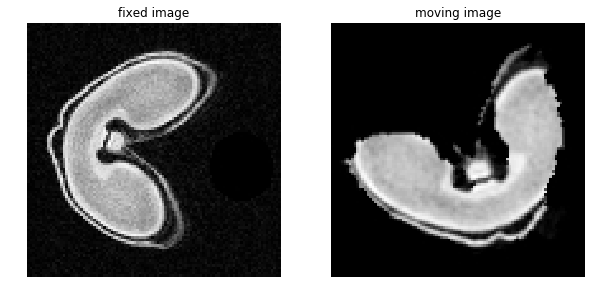

In [25]:
fixed_image =  sitk.ReadImage("/mnt/d/Registration/BLE/250/50/mri.jpg", sitk.sitkFloat32)
moving_image = sitk.ReadImage("/mnt/d/Registration/BLE/250/50/maldi2.jpg", sitk.sitkFloat32) 

interact(display_images, fixed_image_z=0, moving_image_z=0, fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

## Initial Alignment

Use the CenteredTransformInitializer to align the centers of the two volumes and set the center of rotation to the center of the fixed image.

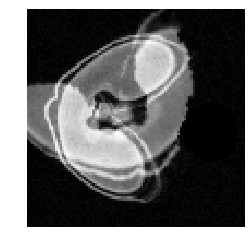

In [26]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                    sitk.Similarity2DTransform(),
                                                      sitk.CenteredTransformInitializerFilter.MOMENTS)
print(initial_transform)
moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
interact(display_images_with_alpha, image_z=(0,1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

## Registration

The specific registration task at hand estimates a 3D rigid transformation between images of different modalities. There are multiple components from each group (optimizers, similarity metrics, interpolators) that are appropriate for the task. Note that each component selection requires setting some parameter values. We have made the following choices:

<ul>
<li>Similarity metric, mutual information (Mattes MI):
<ul>
  <li>Number of histogram bins, 50.</li>
  <li>Sampling strategy, random.</li>
  <li>Sampling percentage, 1%.</li>
</ul>
</li>
<li>Interpolator, sitkLinear.</li>
<li>Optimizer, gradient descent: 
<ul>
  <li>Learning rate, step size along traversal direction in parameter space, 1.0 .</li>
  <li>Number of iterations, maximal number of iterations, 100.</li>
  <li>Convergence minimum value, value used for convergence checking in conjunction with the energy profile of the similarity metric that is estimated in the given window size, 1e-6.</li>
  <li>Convergence window size, number of values of the similarity metric which are used to estimate the energy profile of the similarity metric, 10.</li>
</ul>
</li>
</ul>


Perform registration using the settings given above, and take advantage of the built in multi-resolution framework, use a three tier pyramid.  

In this example we plot the similarity metric's value during registration. Note that the change of scales in the multi-resolution framework is readily visible.

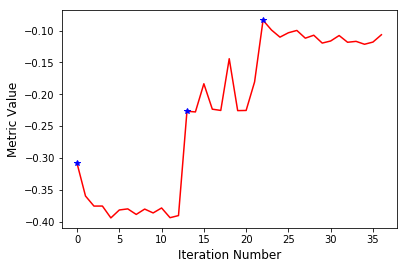

In [46]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=20)
registration_method.SetMetricSamplingPercentage(0.1)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                               sitk.Cast(moving_image, sitk.sitkFloat32))

## Post registration analysis

Query the registration method to see the metric value and the reason the optimization terminated. 

The metric value allows us to compare multiple registration runs as there is a probabilistic aspect to our registration, we are using random sampling to estimate the similarity metric.

Always remember to query why the optimizer terminated. This will help you understand whether termination is too early, either due to thresholds being too tight, early termination due to small number of iterations - numberOfIterations, or too loose, early termination due to large value for minimal change in similarity measure - convergenceMinimumValue)

In [43]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.10734688009642418
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 21.


Now visually inspect the results.

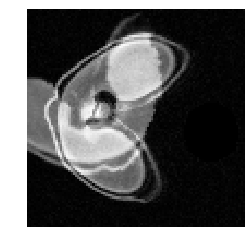

In [44]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

If we are satisfied with the results, save them to file.

In [ ]:
sitk.WriteImage(moving_resampled, os.path.join(OUTPUT_DIR, 'RIRE_training_001_mr_T1_resampled.mha'))
sitk.WriteTransform(final_transform, os.path.join(OUTPUT_DIR, 'RIRE_training_001_CT_2_mr_T1.tfm'))